# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.  

У нас в распоряжении данные о поведении  клиентов, в файле 5 столбцов:
* calls - количество звонков
* minutes - длина звонков
* messages - количество сообщений
* mb_used - интернет-траффик
* is_ultra - абонент использует тариф Ультра(1 - да, 0  -нет)

Проект выполняется в 5 шагов:  
1. Изучение файла
2. Разбиение на выборки
3. Исследование моделей
4. Проверка моделей на тестовой выборке
5. Проверка моделей на адекватрность

## Откройте и изучите файл

Загрузим необходимые библиотеки, откроем файл и посмотрим на него.

In [1]:
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

df = pd.read_csv('/datasets/users_behavior.csv')
display(df)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


Вывод:
* В таблице 3214 строк и 5 стобцов
* Предобработка не требуется
* Целевой признак - is_ultra
* Тип поставленной задачи - классификация

## Разбейте данные на выборки

Определим мультиколлинеарность признаков в целях разгрузки модели.

In [2]:
columns = ['calls','minutes','messages','mb_used', 'is_ultra']
df[columns].corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


Очевидная связь количества звонков и длины разговора. Построим график зависимости.

Коэффициент корреляции: 0.9820832355742293


Text(0.5, 0, 'Длительность разговора')

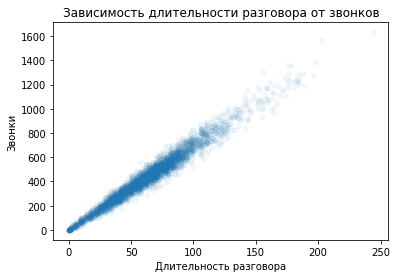

In [3]:
ax = df.plot(x='calls', y='minutes', kind='scatter', alpha=0.05, title = 'Зависимость длительности разговора от звонков') 
print('Коэффициент корреляции:',df['calls'].corr(df['minutes']))
ax.set_ylabel('Звонки') 
ax.set_xlabel("Длительность разговора")

Очевидна зависимость признаков. Отбросим признак количества звонков и оставим длительность разговора - она входит в тарифные условия.  
Разделим данные на 3 выборки - обучающую(60%), тестовую(20%), валидационную(20%). 

In [4]:
df = df.drop(['calls'], axis=1)
df_train, df_valid = train_test_split(df, test_size=0.4, random_state=1)
df_valid, df_test = train_test_split(df_valid, test_size=0.5, random_state=1)
print('Разбиение выборок: ',len(df_train), len(df_valid), len(df_test))

Разбиение выборок:  1928 643 643


## Исследуйте модели

Для сравнения моделей мы будем использовать:
* Дерево решений
* Случайный лес
* Логистическую регрессию  
  
Отделим целевой признак от остальных:

In [5]:
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']

features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

features_vt = features_train.add(features_valid,fill_value=0)
target_vt=target_train.add(target_valid,fill_value=0)

Напишем функцию, которая обучаает модель, запускает прогноз модели и рассчитывает точность модели. И такю же функцию для тестовой выборки.

In [6]:
def model_calc(model):
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    return accuracy_score(target_valid, predictions_valid)
def model_calc_test(model):
    model.fit(features_vt, target_vt)
    predictions_test = model.predict(features_test)
    return accuracy_score(target_test, predictions_test)

### Дерево решений
Данная модель зависит от глубины. Сделаем цикл по глубине дерева и выберем наилучший результат.

In [7]:
for depth in range(1,20):
    model = DecisionTreeClassifier(random_state=1, max_depth=depth)
    print(f'Глубина дерева: {depth}'+', точность {:.3f}'.format(model_calc(model)))

Глубина дерева: 1, точность 0.719
Глубина дерева: 2, точность 0.756
Глубина дерева: 3, точность 0.771
Глубина дерева: 4, точность 0.757
Глубина дерева: 5, точность 0.768
Глубина дерева: 6, точность 0.762
Глубина дерева: 7, точность 0.754
Глубина дерева: 8, точность 0.756
Глубина дерева: 9, точность 0.770
Глубина дерева: 10, точность 0.768
Глубина дерева: 11, точность 0.767
Глубина дерева: 12, точность 0.751
Глубина дерева: 13, точность 0.745
Глубина дерева: 14, точность 0.753
Глубина дерева: 15, точность 0.734
Глубина дерева: 16, точность 0.736
Глубина дерева: 17, точность 0.734
Глубина дерева: 18, точность 0.733
Глубина дерева: 19, точность 0.731


В принципе на этом можно и окончить работу, так как модель дерева решений с глубиной от 2 до 17 отвечает нашим требованиям.  
Вывод:  
* Наилучший результат 0.796 у дерева глубиной 9  


### Случайный лес


Возьмем наилучшую глубину дерева из прошлой модели, иначе прогонять по циклу глубин будет очень долго. Прогоним модель по параметру n_estimators.

In [8]:
best_model = None
best_result = 0
best_est=0
depth=9
for est in range (1,100):
    model = RandomForestClassifier(n_estimators=est, random_state=1, max_depth=depth)
    result = model_calc(model)
    if result > best_result:
        best_model = model
        best_result = result
        best_est = est
print(f'Глубина дерева: {depth}'+f' n_estimators {best_est}'', точность {:.3f}'.format(best_result))

Глубина дерева: 9 n_estimators 28, точность 0.790


Расчет долгий, но он стоит того, точность выше:
* Наилучший результат 0.806 у случайного леса глубиной 9  и n_estimators 7
### Логистическая регрессия

Посмотрим, что она нам выдаст.

In [9]:
model = LogisticRegression(random_state=1)
print(model_calc(model))

0.7107309486780715


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Самая низкая точность из всех использованных моделей.

## Проверьте модель на тестовой выборке

In [10]:
model = RandomForestClassifier(n_estimators=7, random_state=1, max_depth=9)
print(f'Точность модели на тестовой выборке {model_calc_test(model)}')


Точность модели на тестовой выборке 0.807153965785381


## (бонус) Проверьте модели на адекватность

In [11]:
df['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

Для 69% пользователей тарифа Смарт модель сработала на с точностью около 0.80, выбранную модель можно считать адекватной.


## Общий вывод  
В результате работы над проектом выполнено следующее:
* Данные изучены и разбиты на тестовую, валидационную и обучающую выборку.
* На основе данных быди обучены модели дерева решений, случайного леса и логическоой регрессии.
* Модели проверены на на тестовой выборке
* Модели проверены на адекватность  

Основной результат: модель случайного леса и дерева решений показывают точность около 0.80. Модель логической регрессии показывает точность около 0.70. Результаты стоит считать адекватной, так как модели работают с точность до 0.80 для 69% пользователей